In [7]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from copy import copy

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam, pyro_method
from pyro.nn.module import to_pyro_module_
from pyro.poutine import trace, replay
from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam

from pyciemss.ODE.models import SVIIvR
from pyciemss.utils import run_inference

In [8]:
def plot_predictive(prediction, data, title=""):
    t = np.linspace(0, 160, 160)
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    vars = ["S_obs", "V_obs", "I_obs", "Iv_obs", "R_obs"]
    S, V, I, Iv, R = [d.detach().numpy()/1000 for d in data]

    S_low, V_low, I_low, Iv_low, R_low = [torch.quantile(prediction[k], 0.05, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, Iv_up, R_up = [torch.quantile(prediction[k], 0.95, dim=0).detach().numpy()/1000 for k in vars]

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.fill_between(t, S_low, S_up, color='b', alpha=0.2)
    ax.plot(t, V, 'purple', alpha=0.5, lw=2, label='SucceptibleVaccinated')
    ax.fill_between(t, V_low, V_up, color='purple', alpha=0.2)
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.fill_between(t, I_low, I_up, color='r', alpha=0.2)
    ax.plot(t, Iv, 'green', alpha=0.5, lw=2, label='InfectedVaccinated')
    ax.fill_between(t, Iv_low, Iv_up, color='green', alpha=0.2)
    ax.plot(t, R, 'orange', alpha=0.5, lw=2, label='Recovered')
    ax.fill_between(t, R_low, R_up, color='orange', alpha=0.2)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

In [9]:
def get_tspan(start, end, steps):
    return torch.linspace(float(start), float(end), steps)

In [10]:
# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
tspan = get_tspan(0, 160, 160)

In [11]:
# Generate data
ode_model = SVIIvR(N)
S_obs, V_obs, I_obs, Iv_obs, R_obs = ode_model(initial_state, tspan)

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_59263/161055048.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


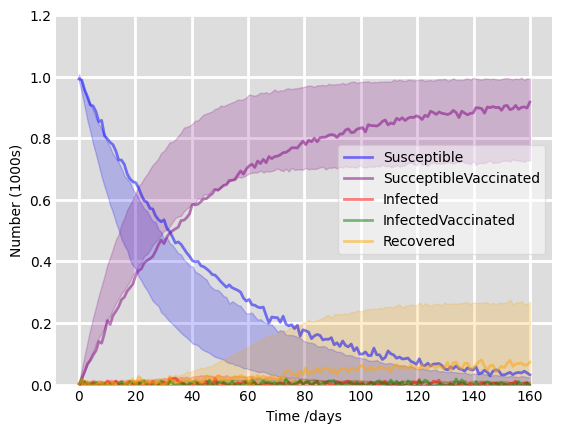

In [12]:
prior_prediction = Predictive(ode_model, num_samples=100)(initial_state, tspan)
plot_predictive(prior_prediction, (S_obs, V_obs, I_obs, Iv_obs, R_obs))

In [13]:
guide = AutoNormal(ode_model)
data = {"S_obs":S_obs, "V_obs":V_obs, "I_obs":I_obs, "Iv_obs":Iv_obs, "R_obs":R_obs}

run_inference(ode_model, guide, initial_state, tspan, data, num_iterations=100, verbose=True)

[iteration 0001] loss: 83130.8035
[iteration 0026] loss: 28085.4056
[iteration 0051] loss: 15942.1601
[iteration 0076] loss: 9936.3471


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_59263/161055048.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


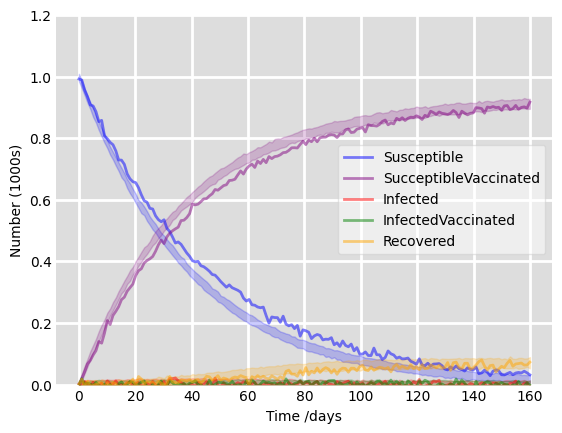

In [14]:
posterior_prediction = Predictive(ode_model, guide=guide, num_samples=100)(initial_state, tspan)
plot_predictive(posterior_prediction, (S_obs, V_obs, I_obs, Iv_obs, R_obs))

In [19]:
use_posterior = False

nu = torch.tensor(0., requires_grad=True)
optimizer = torch.optim.Adam([nu])

controlled_model = lambda nu : pyro.do(ode_model, {"nu": nu})(initial_state, tspan)

for i in range(100):
    if use_posterior:
        # Sample from the approximate posterior and replay through the model.
        # Note: Because we're using the Pytorch optimizer that targets tensors, we don't need to freeze guide parameters.
        guide_tr = trace(guide).get_trace(initial_state, tspan)
        model_tr = trace(replay(controlled_model, trace=guide_tr)).get_trace(nu)
    else:
        model_tr = trace(controlled_model).get_trace(nu)

    # If this value is positive, the constraint is not satisfied.
    relaxed_constraint = torch.max(model_tr.nodes["R_obs"]['value'][-1] - torch.tensor([100.]), torch.tensor([0.]))
    model_tr.nodes["R_obs"]['value'].retain_grad()
    relaxed_constraint.retain_grad()

    # Relaxed constrained optimization
    loss = nu + relaxed_constraint

    optimizer.zero_grad()
    loss.backward()

    if i % 1 == 0:
        print("[iteration %04d] loss: %.4f [nu %.4f]" % (i + 1, loss, nu))

    optimizer.step()

[iteration 0001] loss: 581.9271 [nu 0.0000]
[iteration 0002] loss: 631.8833 [nu 0.0010]
[iteration 0003] loss: 697.7147 [nu 0.0020]
[iteration 0004] loss: 688.5168 [nu 0.0029]
[iteration 0005] loss: 391.7765 [nu 0.0039]
[iteration 0006] loss: 372.4465 [nu 0.0048]
[iteration 0007] loss: 0.0058 [nu 0.0058]
[iteration 0008] loss: 152.9466 [nu 0.0067]
[iteration 0009] loss: 0.0075 [nu 0.0075]
[iteration 0010] loss: 207.3935 [nu 0.0083]
[iteration 0011] loss: 587.5905 [nu 0.0092]
[iteration 0012] loss: 170.4964 [nu 0.0100]
[iteration 0013] loss: 324.9409 [nu 0.0109]
[iteration 0014] loss: 543.7491 [nu 0.0117]
[iteration 0015] loss: 124.4717 [nu 0.0126]
[iteration 0016] loss: 0.0134 [nu 0.0134]
[iteration 0017] loss: 514.1440 [nu 0.0142]
[iteration 0018] loss: 0.0150 [nu 0.0150]
[iteration 0019] loss: 504.3393 [nu 0.0157]
[iteration 0020] loss: 45.9966 [nu 0.0164]
[iteration 0021] loss: 412.0938 [nu 0.0171]
[iteration 0022] loss: 0.0178 [nu 0.0178]
[iteration 0023] loss: 341.2140 [nu 0.0185]